In [5]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Full DataFrame:
   Lead Time  censoring_threshold Architecture Class  Train Loss  Dev Loss  Test Loss  Optimality Gap %  Learning Rate
0          2                    4            Vanilla    3.642739  3.636712   4.552507          3.466062            NaN
0          2                    4  Capped Base Stock    3.653002  3.648206   4.615443          4.896434          0.010
1          2                    5            Vanilla    3.860333  3.848800   4.419297          0.438572            NaN
1          2                    5  Capped Base Stock    3.889230  3.876462   4.445677          1.038104          0.001
2          2                    6            Vanilla    4.091585  4.093121   4.397026         -0.067583            NaN
2          2                    6  Capped Base Stock    4.187545  4.181600   4.445677          1.038104          0.100
3          2                    7            Vanilla    4.253862  4.246493   4.395808         -0.095263            NaN
3          2                   

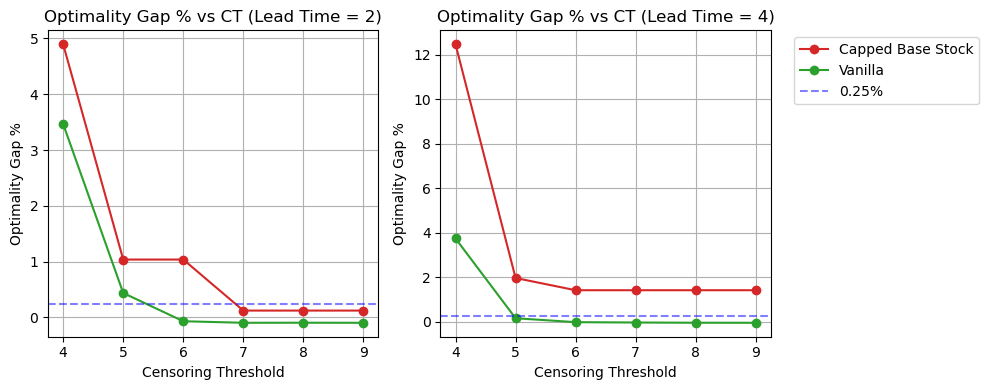

In [8]:
# Define color scheme for architecture types
color_scheme = {
    "Vanilla": "#2ca02c",  # Green
    "Capped Base Stock": "#d62728",  # Red
}

linestyle_scheme = {
    "Vanilla": "-",  # Solid
    "Capped Base Stock": "-",  # Solid
}

path = 'one_store_lost_demands_censored'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()
# Create figure with 2 subplots vertically stacked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

all_dfs = []
optimal_losses = {2: 4.40, 4: 4.73}  # Optimal losses for each lead time
for lead_time in [2, 4]:
    dfs = []
    censoring_threshold = [4, 5, 6, 7, 8, 9]
    df_vanilla = results_interpretor.make_table(vanilla_paths,
        {'censoring_threshold': censoring_threshold, 'store_lead_time': [lead_time]},
        default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_vanilla.insert(2, 'Architecture Class', "Vanilla")
    df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_store")
    df_vanilla['Censoring Threshold'] = censoring_threshold
    df_vanilla['Lead Time'] = lead_time
    
    # Capped Base Stock for this threshold
    df_capped = results_interpretor.make_table(capped_base_stock_paths,
        {'censoring_threshold': censoring_threshold, 'store_lead_time': [lead_time]},
        default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
    df_capped.insert(1, 'hyperparam_name', "capped_base_stock")
    df_capped['Censoring Threshold'] = censoring_threshold
    df_capped['Lead Time'] = lead_time
    dfs.extend([df_vanilla, df_capped])

    # Combine all dataframes for this lead time
    df = pd.concat(dfs)

    optimal_loss = optimal_losses[lead_time]
    df['Optimality Gap %'] = ((df['Test Loss'] - optimal_loss) / optimal_loss) * 100
    df.insert(df.columns.get_loc(df.columns[-2]), 'Optimality Gap %', df.pop('Optimality Gap %'))
    df.sort_values(by=['Censoring Threshold'], inplace=True)

    # Create pivot table
    pivot_df = df.groupby(['Censoring Threshold', 'Architecture Class'])['Optimality Gap %'].mean().unstack()

    # Plot lines for each architecture
    ax = ax1 if lead_time == 2 else ax2
    for column in pivot_df.columns:
        ax.plot(pivot_df.index, pivot_df[column],
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle=linestyle_scheme[column])

    # Add 0.25% gap line
    ax.axhline(y=0.25, color='blue', linestyle='--', alpha=0.5, label='0.25%')

    ax.set_xlabel('Censoring Threshold')
    ax.set_ylabel('Optimality Gap %')
    ax.set_title(f'Optimality Gap % vs CT (Lead Time = {lead_time})')
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    
    # Only add legend to the first plot
    if lead_time == 4:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    all_dfs.append(df)

# Combine data from both lead times
combined_df = pd.concat(all_dfs)
combined_df.sort_values(by=['Lead Time', 'Censoring Threshold'], inplace=True)

# Print the full dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
combined_df.drop(columns=['# of stores', 'hyperparam_name', '# of runs', 'path', 'Censoring Threshold', 'Lead Time'], inplace=True)
combined_df.insert(0, 'Lead Time', combined_df.pop('store_lead_time'))
print("\nFull DataFrame:")
print(combined_df.to_string())

plt.tight_layout()
plt.show()

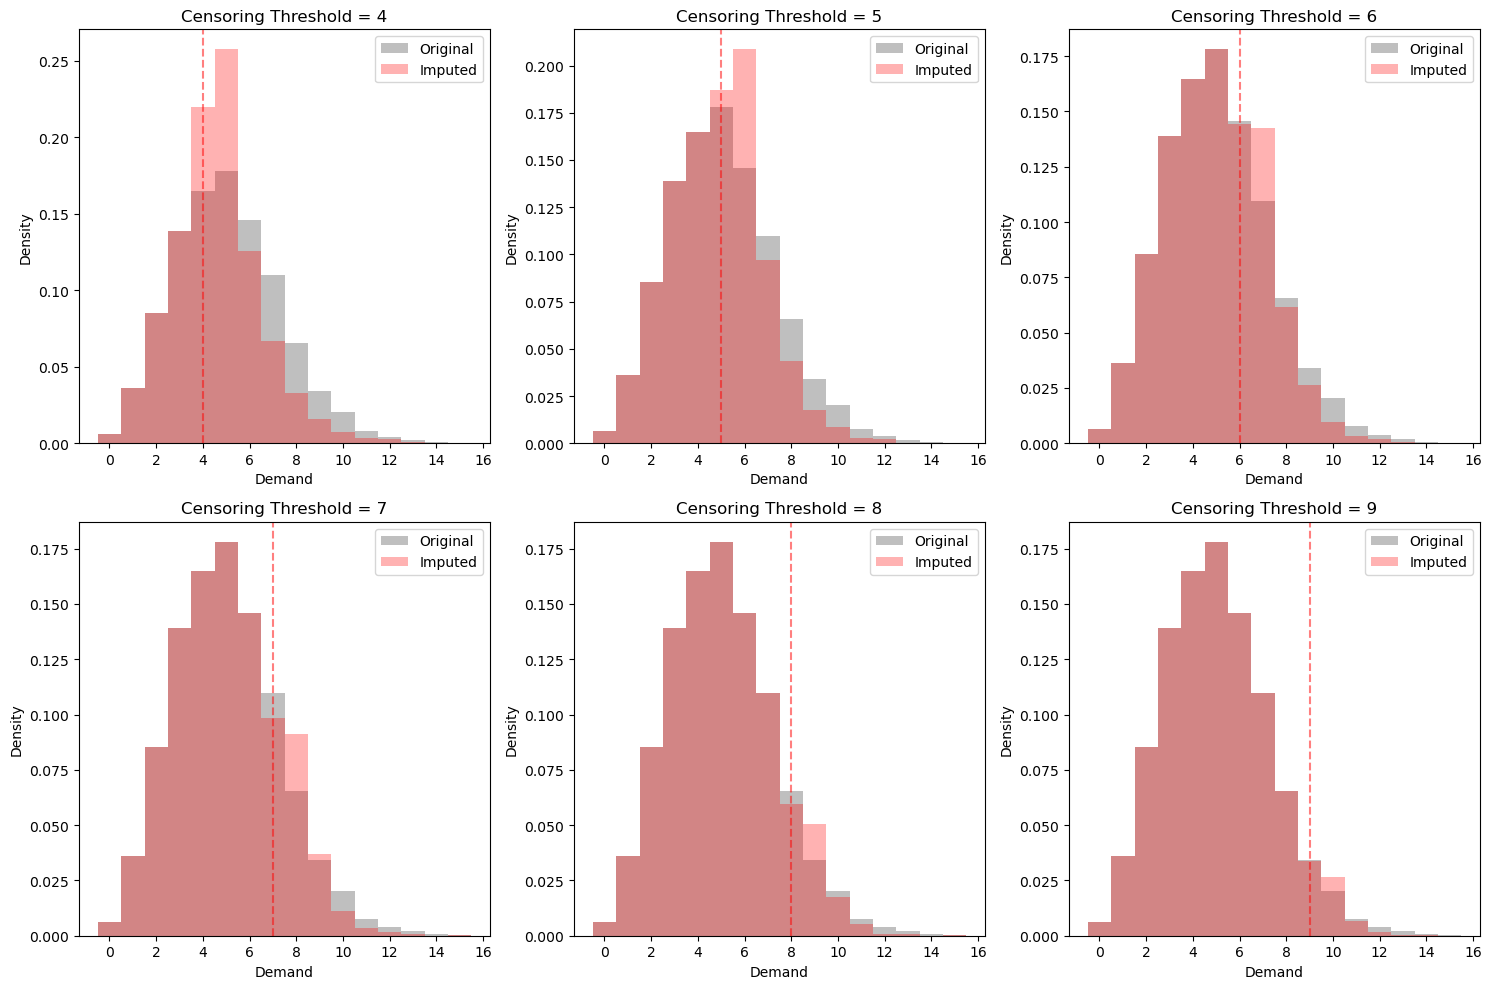

In [27]:
import scipy.stats as stats
import scipy.optimize as optimize
class PoissonDemandGenerator:
    def __init__(self, num_samples, periods):
        self.num_samples = num_samples
        self.periods = periods

    def estimate_exponential_tail_rate(self, samples, M, n_tail_buckets=3):
        flat_samples = samples.flatten()

        tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples < M)]
        
        def neg_log_likelihood(rate):
            return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
        result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
        
        return result.x

    def generate_censored_demand(self, problem_params, demand_params, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        M = problem_params.get('censoring_threshold', 7)
        
        orig_samples = np.random.poisson(
            demand_params['mean'], 
            size=(self.num_samples, problem_params['n_stores'], self.periods)
        )
        imputed_samples = np.minimum(orig_samples, M)
        censored_mask = orig_samples >= M
        lambda_exp = self.estimate_exponential_tail_rate(orig_samples, M)
        censored_tails = np.round(
            M + np.random.exponential(1/lambda_exp, size=np.sum(censored_mask))
        ).astype(int)
        
        imputed_samples[censored_mask] = censored_tails
        return orig_samples, imputed_samples

# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
thresholds = [4, 5, 6, 7, 8, 9]

generator = PoissonDemandGenerator(num_samples=8192, periods=1)
demand_params = {'mean': 5.0}

for i, M in enumerate(thresholds):
    row = i // 3
    col = i % 3
    
    problem_params = {'censoring_threshold': M, 'n_stores': 1}
    orig, imputed = generator.generate_censored_demand(problem_params, demand_params, seed=57)
    
    # Flatten arrays for histogram
    orig_flat = orig.flatten()
    imputed_flat = imputed.flatten()
    
    # Plot histograms
    bins = np.arange(0, max(orig_flat.max(), imputed_flat.max()) + 2) - 0.5
    axs[row, col].hist(orig_flat, bins=bins, alpha=0.5, density=True, label='Original', color='grey')
    axs[row, col].hist(imputed_flat, bins=bins, alpha=0.3, density=True, label='Imputed', color='red')
    
    # Add vertical line at threshold
    axs[row, col].axvline(x=M, color='r', linestyle='--', alpha=0.5)
    
    axs[row, col].set_title(f'Censoring Threshold = {M}')
    axs[row, col].set_xlabel('Demand')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend()

plt.tight_layout()
plt.show()